# Labs Access Analysis: 05 Population Analysis with Facebook Data

## Setup

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import os
import gc
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore') # ignore warnings

/Users/massimo/Documents/GitHub/labs_access_analysis/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
sns.set_context("poster")
sns.set_style(style="whitegrid")
matplotlib.rc('font', family='serif', serif='Fira Sans')

In [3]:
# create the directory with the data
if not os.path.exists('data'):
    os.makedirs('data') 
# create the directory where store the svg files
if not os.path.exists('svg'):
    os.makedirs('svg') 
# create the directory with the png files
if not os.path.exists('png'):
    os.makedirs('png')


In [4]:
url_data_labs = "https://openp2pdesign.github.io/labs_access_analysis/data/labs.csv"
url_data_isochrones = "https://openp2pdesign.github.io/labs_access_analysis/data/isochrones.json"
##REMOVE these lines when you are ready to publish the data
url_data_labs = "data/labs.csv"
url_data_isochrones = "data/isochrones.json"

## Load the data of the labs

load the data with valid coordinates

In [5]:
# Load data, csv
data_csv = pd.read_csv(url_data_labs)
data_csv['Lat'] = data_csv['Lat'].astype(float)
data_csv['Long'] = data_csv['Long'].astype(float)
data_csv = data_csv[(((~data_csv.Lat.isnull()) & (~data_csv.Long.isnull())))]

In [6]:
data_labs = gpd.GeoDataFrame(
    data_csv,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(data_csv.Long, data_csv.Lat))

show the first 5 rows

In [7]:
data_labs.head(5)

,Name,Type,City,Cluster,Address,CAP,Lat,Long,Source,URL,Notes,URL 2,geometry
0,3D Incubator,Incubator-Accelerator,Barcelona,BCN,"Polígono Industrial de la, Avinguda Parc Logís...",8040.0,41.340036,2.123036,Manually added,https://www.incubator3d.org/,NaN,NaN,POINT (2.12304 41.34004)
1,AKASHA Hub Barcelona,Hackerspace,Barcelona,BCN,"carrer de la verneda, 17 loc1",8018.0,41.411054,2.191146,Hackerspaces.org,https://wiki.hackerspaces.org/AKASHA_Hub_Barce...,NaN,NaN,POINT (2.19115 41.41105)
2,Ateneu de Fabricació Ca L'Alier,Ateneu de Fabricació,Barcelona,BCN,"Carrer de Pere IV, 362",8019.0,41.410786,2.203873,Ajuntament.barcelona.cat,NaN,NaN,NaN,POINT (2.20387 41.41079)
3,Ateneu de Fabricació Ciutat Meridiana,Ateneu de Fabricació,Barcelona,BCN,"Av. de Rasos de Peguera, 232",8033.0,41.460460,2.169872,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.16987 41.46046)
4,Ateneu de Fabricació Gràcia,Ateneu de Fabricació,Barcelona,BCN,Carrer Perill 8,8012.0,41.399364,2.161167,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.16117 41.39936)


In [8]:
#data_labs.set_index('Unnamed: 0', inplace=True)
#data_labs.index.names = ['']

show the data on map

In [9]:
data_labs.explore()

## Analyse the isochrones

load the data

In [10]:
isochrones = pd.read_json(url_data_isochrones)

show the first 5 rows

In [11]:
isochrones.head(5)

,type,bbox,features,metadata,name
0,FeatureCollection,"[2.109858, 41.333106, 2.136626, 41.345904]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,3D Incubator
1,FeatureCollection,"[2.178987, 41.399645, 2.2038, 41.422588]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,AKASHA Hub Barcelona
2,FeatureCollection,"[2.190682, 41.399878, 2.217599, 41.42188]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Ateneu de Fabricació Ca L'Alier
3,FeatureCollection,"[2.162366, 41.45557, 2.182231, 41.467255]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Ateneu de Fabricació Ciutat Meridiana
4,FeatureCollection,"[2.148282, 41.389167, 2.175835, 41.409659]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Ateneu de Fabricació Gràcia


create the geodataframe

In [12]:
isochrones['longitude'] = isochrones['metadata'].apply(lambda x: x['query']['locations'][0][0])
isochrones['latitude'] = isochrones['metadata'].apply(lambda x: x['query']['locations'][0][1])
isochrones['area_units'] = isochrones['metadata'].apply(lambda x: x['query']['area_units'])

In [13]:
isochrones['total_pop'] = isochrones['features'].apply(lambda x: x[0]['properties']['total_pop'])
isochrones['area'] = isochrones['features'].apply(lambda x:x[0]['properties']['area'])
isochrones['reachfactor'] = isochrones['features'].apply(lambda x: x[0]['properties']['reachfactor'])

In [14]:
isochrones['coordinates'] = isochrones['features'].apply(lambda x: x[0]['geometry']['coordinates'])
isochrones['geometry_type'] = isochrones['features'].apply(lambda x: x[0]['geometry']['type'])

In [15]:
isochrones['geometry'] = isochrones['coordinates'].apply(lambda x: Polygon(x[0]))

In [16]:
isochrones = isochrones[['name','longitude','latitude','total_pop','area','reachfactor','geometry']]

In [17]:
isochrones = gpd.GeoDataFrame(
    isochrones,
    geometry=isochrones.geometry,
    crs='EPSG:4326')

show the isochrones on a map

In [18]:
isochrones.explore()

show the first 5 rows

In [19]:
isochrones.head(5)

,name,longitude,latitude,total_pop,area,reachfactor,geometry
0,3D Incubator,2.123036,41.340036,25847.0,1257375.85,0.2562,"POLYGON ((2.10986 41.33668, 2.11147 41.33429, ..."
1,AKASHA Hub Barcelona,2.191146,41.411054,96774.0,4573263.53,0.9317,"POLYGON ((2.17899 41.41306, 2.17919 41.40872, ..."
2,Ateneu de Fabricació Ca L'Alier,2.203873,41.410786,93219.0,4526884.39,0.9222,"POLYGON ((2.19068 41.40472, 2.19217 41.40230, ..."
3,Ateneu de Fabricació Ciutat Meridiana,2.169872,41.460460,11587.0,1595247.01,0.3250,"POLYGON ((2.16237 41.46718, 2.16239 41.46698, ..."
4,Ateneu de Fabricació Gràcia,2.161167,41.399364,97329.0,4510074.18,0.9188,"POLYGON ((2.14828 41.39726, 2.14829 41.39720, ..."


save as geojson file

In [20]:
isochrones.to_file("data" + os.sep + "lab_isochrones.geojson",driver='GeoJSON')

### merge the attributes of the isochrones with the data of the labs
rename columns

In [21]:
columns = {
    'name': 'Name'
}
isochrones.rename(columns=columns, inplace=True)

In [22]:
labs = isochrones.merge(data_labs, on="Name")
labs = gpd.GeoDataFrame(labs)

In [23]:
columns = {
    'geometry_x': 'geometry'
}
labs.rename(columns=columns, inplace=True)

read the first 5 rows

In [24]:
labs.head(5)

,Name,longitude,latitude,total_pop,area,reachfactor,geometry,Type,City,Cluster,Address,CAP,Lat,Long,Source,URL,Notes,URL 2,geometry_y
0,3D Incubator,2.123036,41.340036,25847.0,1257375.85,0.2562,"POLYGON ((2.10986 41.33668, 2.11147 41.33429, ...",Incubator-Accelerator,Barcelona,BCN,"Polígono Industrial de la, Avinguda Parc Logís...",8040.0,41.340036,2.123036,Manually added,https://www.incubator3d.org/,NaN,NaN,POINT (2.12304 41.34004)
1,AKASHA Hub Barcelona,2.191146,41.411054,96774.0,4573263.53,0.9317,"POLYGON ((2.17899 41.41306, 2.17919 41.40872, ...",Hackerspace,Barcelona,BCN,"carrer de la verneda, 17 loc1",8018.0,41.411054,2.191146,Hackerspaces.org,https://wiki.hackerspaces.org/AKASHA_Hub_Barce...,NaN,NaN,POINT (2.19115 41.41105)
2,Ateneu de Fabricació Ca L'Alier,2.203873,41.410786,93219.0,4526884.39,0.9222,"POLYGON ((2.19068 41.40472, 2.19217 41.40230, ...",Ateneu de Fabricació,Barcelona,BCN,"Carrer de Pere IV, 362",8019.0,41.410786,2.203873,Ajuntament.barcelona.cat,NaN,NaN,NaN,POINT (2.20387 41.41079)
3,Ateneu de Fabricació Ciutat Meridiana,2.169872,41.460460,11587.0,1595247.01,0.3250,"POLYGON ((2.16237 41.46718, 2.16239 41.46698, ...",Ateneu de Fabricació,Barcelona,BCN,"Av. de Rasos de Peguera, 232",8033.0,41.460460,2.169872,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.16987 41.46046)
4,Ateneu de Fabricació Gràcia,2.161167,41.399364,97329.0,4510074.18,0.9188,"POLYGON ((2.14828 41.39726, 2.14829 41.39720, ...",Ateneu de Fabricació,Barcelona,BCN,Carrer Perill 8,8012.0,41.399364,2.161167,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.16117 41.39936)


In [25]:
columns = {
    'Name': 'name',
    'Type': 'type',
    'City': 'city',
    'Cluster':  'cluster',
    'Address': 'address',
    'CAP': 'zipcode',
    'Source': 'source',
    'URL': 'url',
    'Notes': 'notes',
    'geomtry_y': 'geomtry'
}
labs.rename(columns=columns, inplace=True)

In [26]:
#labs.to_file("data/labs_isochrones.geojson",driver='GeoJSON')

## Analysis of Facebook data

### setup and functions

In [27]:
labs_ita = labs[labs.cluster == "MI"]
labs_esp = labs[labs.cluster == "BCN"]
labs_ita = gpd.GeoDataFrame(labs_ita)
labs_esp = gpd.GeoDataFrame(labs_esp)

In [28]:
labs_ita.set_crs(epsg=4326, inplace=True)
labs_esp.set_crs(epsg=4326, inplace=True)

,name,longitude,latitude,total_pop,area,reachfactor,geometry,type,city,cluster,address,zipcode,Lat,Long,source,url,notes,URL 2,geometry_y
0,3D Incubator,2.123036,41.340036,25847.0,1257375.85,0.2562,"POLYGON ((2.10986 41.33668, 2.11147 41.33429, ...",Incubator-Accelerator,Barcelona,BCN,"Polígono Industrial de la, Avinguda Parc Logís...",8040.0,41.340036,2.123036,Manually added,https://www.incubator3d.org/,NaN,NaN,POINT (2.12304 41.34004)
1,AKASHA Hub Barcelona,2.191146,41.411054,96774.0,4573263.53,0.9317,"POLYGON ((2.17899 41.41306, 2.17919 41.40872, ...",Hackerspace,Barcelona,BCN,"carrer de la verneda, 17 loc1",8018.0,41.411054,2.191146,Hackerspaces.org,https://wiki.hackerspaces.org/AKASHA_Hub_Barce...,NaN,NaN,POINT (2.19115 41.41105)
2,Ateneu de Fabricació Ca L'Alier,2.203873,41.410786,93219.0,4526884.39,0.9222,"POLYGON ((2.19068 41.40472, 2.19217 41.40230, ...",Ateneu de Fabricació,Barcelona,BCN,"Carrer de Pere IV, 362",8019.0,41.410786,2.203873,Ajuntament.barcelona.cat,NaN,NaN,NaN,POINT (2.20387 41.41079)
3,Ateneu de Fabricació Ciutat Meridiana,2.169872,41.460460,11587.0,1595247.01,0.3250,"POLYGON ((2.16237 41.46718, 2.16239 41.46698, ...",Ateneu de Fabricació,Barcelona,BCN,"Av. de Rasos de Peguera, 232",8033.0,41.460460,2.169872,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.16987 41.46046)
4,Ateneu de Fabricació Gràcia,2.161167,41.399364,97329.0,4510074.18,0.9188,"POLYGON ((2.14828 41.39726, 2.14829 41.39720, ...",Ateneu de Fabricació,Barcelona,BCN,Carrer Perill 8,8012.0,41.399364,2.161167,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.16117 41.39936)
5,Ateneu de Fabricació La Fàbrica del Sol / Espa...,2.191718,41.382352,48218.0,2807067.38,0.5719,"POLYGON ((2.17749 41.38527, 2.17750 41.38264, ...",Ateneu de Fabricació / Barcelona Recircula – T...,Barcelona,BCN,"Passeig de Salvat Papasseit, 1",8003.0,41.382352,2.191718,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,https://bcnsostenible.cat/web/punt/espai-dinte...,POINT (2.19172 41.38235)
6,Ateneu de Fabricació Les Corts,2.135464,41.383661,88373.0,4220282.63,0.8597,"POLYGON ((2.12253 41.38159, 2.12292 41.37729, ...",Ateneu de Fabricació,Barcelona,BCN,c/ Evarist Arnús 59 i c/ Comtes de Bell-Lloc 192,8014.0,41.383661,2.135464,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.13546 41.38366)
7,Ateneu de Fabricació Parc Tecnológic,2.168955,41.436965,83897.0,4259804.83,0.8678,"POLYGON ((2.15492 41.43672, 2.15658 41.43369, ...",Ateneu de Fabricació,Barcelona,BCN,"Carrer de Marie Curie, 8-14",8042.0,41.436965,2.168955,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.16896 41.43696)
8,ATTA33,2.189540,41.400318,93252.0,4657447.19,0.9488,"POLYGON ((2.17578 41.40184, 2.17579 41.40177, ...",Service,Barcelona,BCN,"Carrer de Tànger, 33",8018.0,41.400318,2.189540,Manually added,https://atta33.com/,NaN,NaN,POINT (2.18954 41.40032)
9,Barcelona Mobility LAB,2.199793,41.432152,44110.0,2136107.60,0.4352,"POLYGON ((2.18942 41.43535, 2.18988 41.43245, ...",Fab Lab,Barcelona,BCN,Passatge del Torrent de l'Estadella 56,8030.0,41.432152,2.199793,Fablabs.io,NaN,NaN,NaN,POINT (2.19979 41.43215)


In [29]:
labs_ita.head(3)

,name,longitude,latitude,total_pop,area,reachfactor,geometry,type,city,cluster,address,zipcode,Lat,Long,source,url,notes,URL 2,geometry_y
15,DamASpace,9.179818,45.452457,59746.0,4910677.26,1.0000,"POLYGON ((9.16413 45.45124, 9.16489 45.44772, ...",Fab Lab,Milan,MI,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,NaN,NaN,POINT (9.17982 45.45246)
26,FabLabMilano - Fare le Idee / ShapeMode / Loca...,9.173905,45.489169,33427.0,2608277.99,0.5314,"POLYGON ((9.15949 45.48736, 9.16037 45.48509, ...",Fab Lab / Incubator-Accelerator,Milan,MI,Via Galileo Ferraris 1,20154.0,45.489169,9.173905,Fablabs.io,https://fablabs.io/labs/fablabmilano,NaN,NaN,POINT (9.17391 45.48917)
33,Kinlab,9.137325,45.475429,50408.0,4335015.57,0.8831,"POLYGON ((9.12152 45.47500, 9.12268 45.47202, ...",DIYBio Lab,Milan,MI,Piazza Segesta 3,20148.0,45.475429,9.137325,Manually added,http://kinlab.it/,NaN,NaN,POINT (9.13733 45.47543)


functions needed to the analysis

In [30]:
def getgeodataframearea(points,x,y):
    global isochrones
    env = env = isochrones.envelope.unary_union.bounds
    area = points[(points[x] >= env[0]) & (points[x] <= env[2]) & (points[y] >= env[1]) & (points[y] <= env[3])]
    geodataframe = gpd.GeoDataFrame(
        points,
        crs='EPSG:4326',
        geometry=gpd.points_from_xy(points[x], points[y]))
    return geodataframe

In [31]:
def adddatafromfile(data, file, column, datacolumn, coordcolname, tab):
    if tab:
        new_data = pd.read_csv(file, sep='\t')
    else:
        new_data = pd.read_csv(file)
    if coordcolname == "LatLon":
        new_data.rename({'Lon': 'longitude', 'Lat': 'latitude', 'Population': 'population'}, axis=1, inplace=True)
    else:
        new_data.rename({datacolumn: 'population'}, axis=1, inplace=True)
    points_cluster = getgeodataframearea(new_data,x='longitude',y='latitude')
    # save memory - destroy dataframe unused
    # del [[isochrones,ita_population,ita_15_24]]
    del [[new_data]]
    gc.collect()
    isochrones=pd.DataFrame()
    new_data=pd.DataFrame()
    sjoin_lab_points = points_cluster.sjoin(data, how='inner')
    data[column] = data.name.apply(lambda x: round(sjoin_lab_points[sjoin_lab_points.name == x].population.sum()))
    return

#### add data for Italy

In [32]:
prefix = "data" + os.sep + "hdx" + os.sep
adddatafromfile(data=labs_ita, file= prefix + "population_ita_2019-07-01.csv", column='total', datacolumn="Population", coordcolname="LatLon", tab=False)

In [33]:
adddatafromfile(data=labs_ita, file= prefix+ "ITA_men_2019-08-03.csv", column='men', datacolumn="population", coordcolname="LatitudeLongitude", tab=True)

In [34]:
adddatafromfile(data=labs_ita, file= prefix + "ITA_women_2019-08-03.csv", column='women', datacolumn="population", coordcolname="LatitudeLongitude", tab=True)

#### add for Spain

In [35]:
adddatafromfile(data=labs_esp, file= prefix + "esp_general_2020.csv", column='total', datacolumn="esp_general_2020", coordcolname="LatitudeLongitude", tab=False)

In [36]:
adddatafromfile(data=labs_esp, file= prefix + "esp_men_2020.csv", column='men', datacolumn="esp_men_2020", coordcolname="LatitudeLongitude", tab=False)

In [37]:
adddatafromfile(data=labs_esp, file= prefix + "esp_women_2020.csv", column='women', datacolumn="esp_women_2020", coordcolname="LatitudeLongitude", tab=False)

### Plot Data

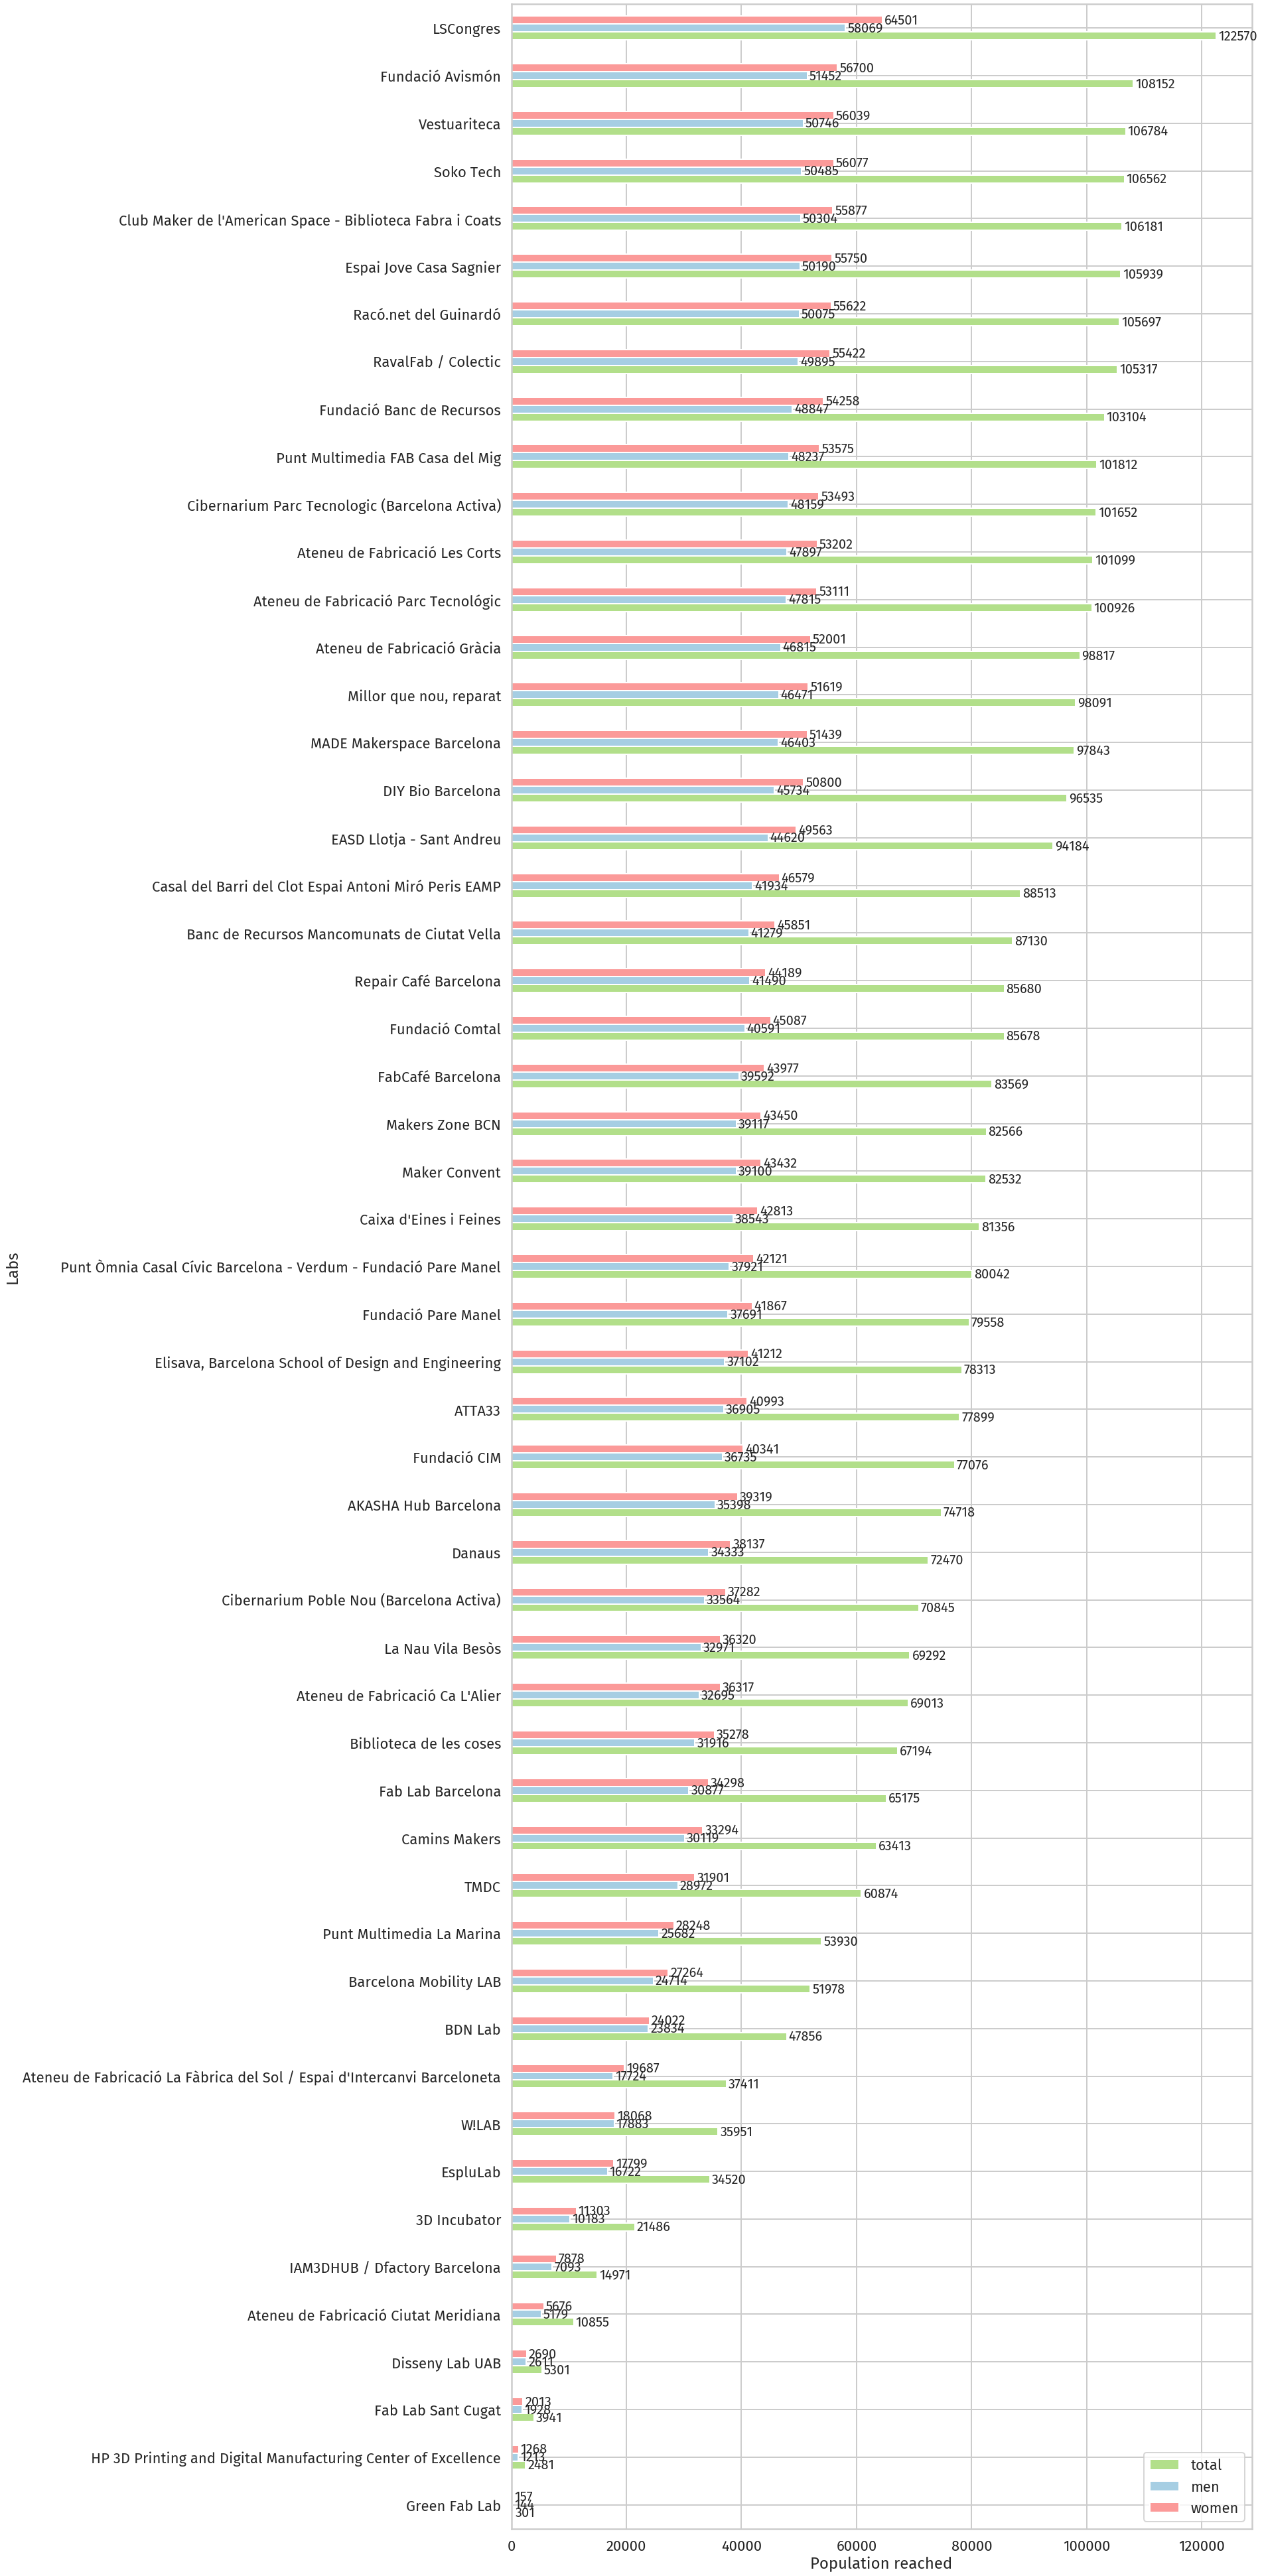

In [38]:
# Plot the data
colors = [sns.color_palette("Paired")[2],sns.color_palette("Paired")[0],sns.color_palette("Paired")[4]]
ax = labs_esp.set_index("name").sort_values(by=["total"])[["total", "men", "women"]].plot(kind="barh", color=colors, figsize=(20,70))
ax.bar_label(ax.containers[0], fmt="%d", size=20, padding=3)
ax.bar_label(ax.containers[1], fmt="%d", size=20, padding=3)
ax.bar_label(ax.containers[2], fmt="%d", size=20, padding=3)
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "labs_esp_fbpop_tot.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "labs_esp_fbpop_tot.png", dpi=300, bbox_inches="tight")

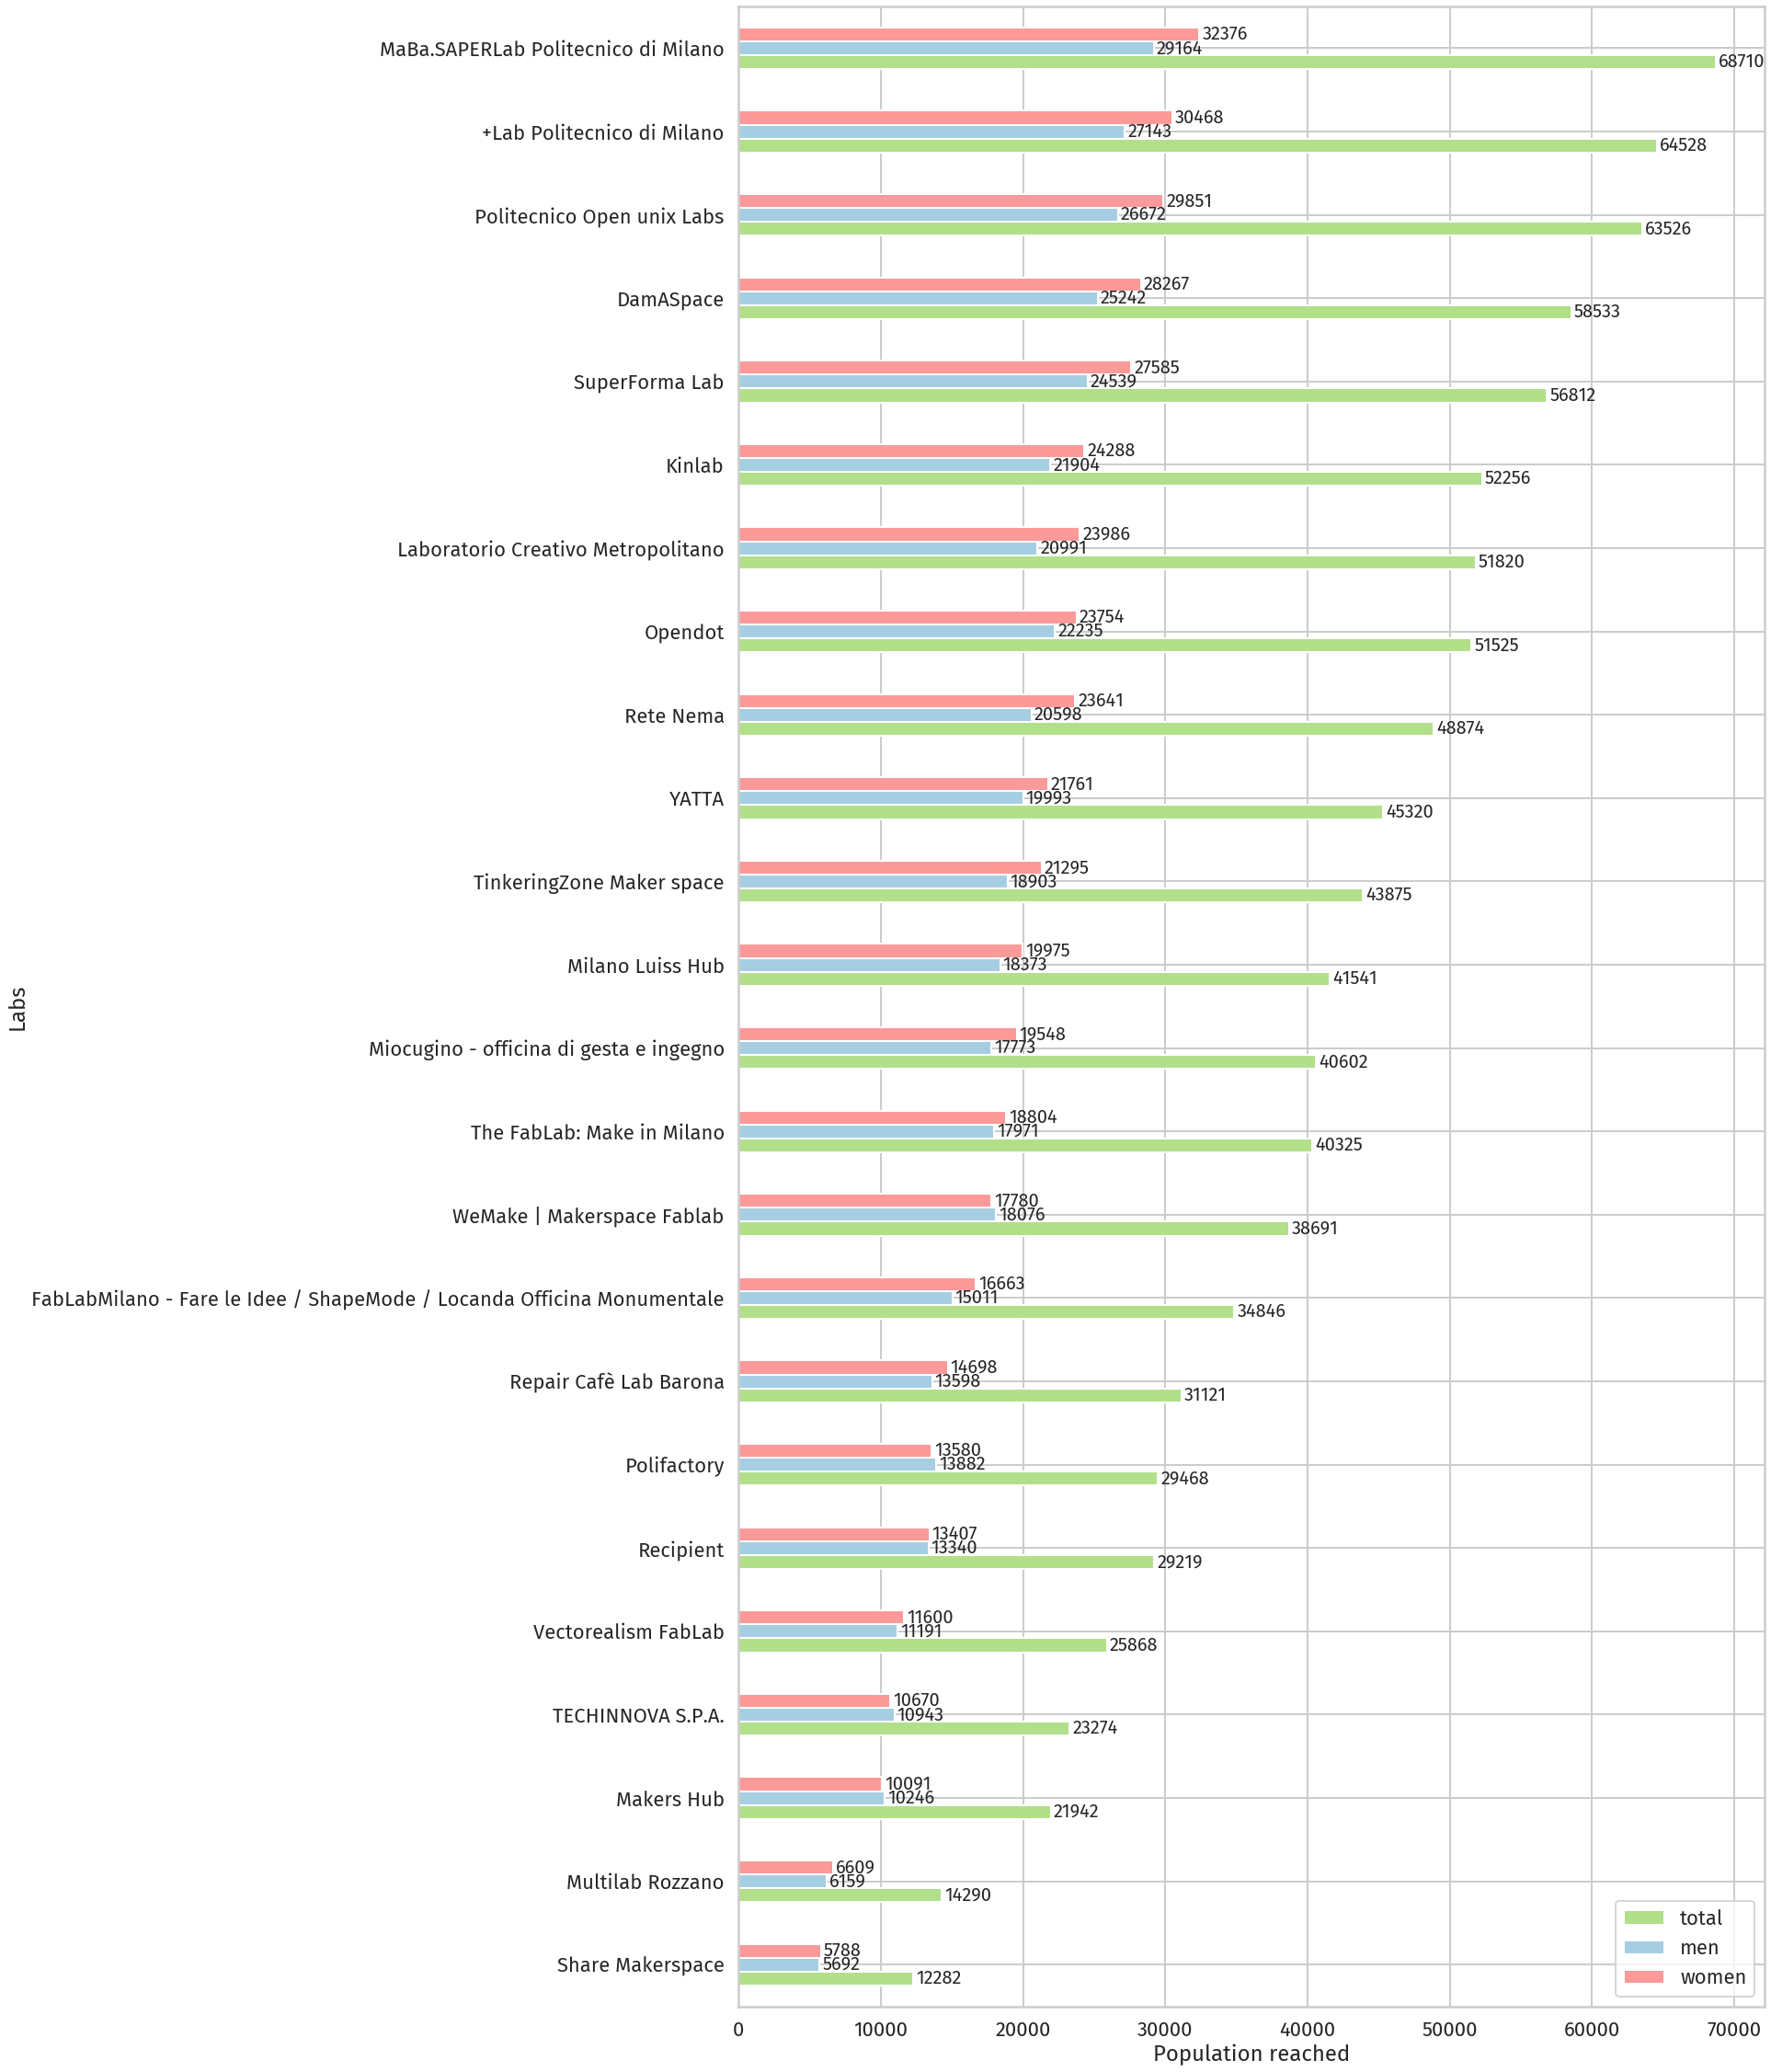

In [39]:
# Plot the data
colors = [sns.color_palette("Paired")[2],sns.color_palette("Paired")[0],sns.color_palette("Paired")[4]]
ax = labs_ita.set_index("name").sort_values(by=["total"])[["total", "men", "women"]].plot(kind="barh", color=colors, figsize=(20,40))
ax.bar_label(ax.containers[0], fmt="%d", size=20, padding=3)
ax.bar_label(ax.containers[1], fmt="%d", size=20, padding=3)
ax.bar_label(ax.containers[2], fmt="%d", size=20, padding=3)
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "labs_ita_fbpop_tot.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "labs_ita_fbpop_tot.png", dpi=300, bbox_inches="tight")

Export the data

In [40]:
labs_esp.to_csv("data" + os.sep + "labs_esp.csv")
labs_ita.to_csv("data" + os.sep + "labs_ita.csv")